**What's in this notebook?** This notebook explains how to work with the data provided in the repository. It also validates the dS solution for example 1 from section 5.1 from the paper.

(*Created:* Andreas Schachner, June 18, 2024)

# Imports

In [1]:
import os, gzip, pickle, sys
import pandas as pd
import numpy as np

# CYTools imports
from cytools import Polytope

# Plotting tools
import matplotlib.pyplot as plt

try:
    import seaborn as sn
except:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'seaborn'])
    import seaborn as sn

# Import custom libraries
sys.path.append("../code/")

# Import loading function
from utils import load_zipped_pickle

# Import F-terms for the complex structure moduli and the axiodilaton
from flux_vacua import fterms_flux

# Import functions to compute corrected CY and divisor volumes
from kahler_stabilisation import compute_corrected_cy_volume, compute_corrected_divisor_volumes

# Import scalar potential for Kähler moduli and its gradient
from kahler_stabilisation import potential_km, gradient_potential_km

# Import function to compute non-perturbative superpotential for Kähler moduli from data
from validation import get_nonpert_superpotential_AdS

# Load data for de Sitter vacua

We load the data as follows

In [2]:
filename = os.getcwd()+ f"/../data/dS_examples/data.p"

df = load_zipped_pickle(filename)

As explained in the notebook [reading_data.ipynb](reading_data.ipynb), we can e.g. display some of the properties here as follows:

In [3]:
# Pick keys that we want to display below
display_keys = ['paper name','paper section',"h11","h21","polyID","modelID","gs","W0","gsM","V dS"]

# Show entries of the dataframe for these keys
df[display_keys]

,paper name,paper section,h11,h21,polyID,modelID,gs,W0,gsM,V dS
0,example 1,5.1,150,8,28,15,0.065695,0.011498+0.000000j,1.051115,1.937130e-19
1,example 2,5.2,150,8,28,10,0.057086,0.004902+0.000000j,0.913383,1.691952e-20
2,example 3,5.3,150,8,28,0,0.044226,-0.022230-0.000000j,0.796066,4.983236e-19
3,example 4,5.4,93,5,8,0,0.040376,0.053857-0.000000j,0.807523,2.340918e-15
4,example 5,5.5,93,5,9,0,0.046594,-0.030393-0.000000j,0.745512,2.112730e-15


As one easily confirms, these are precisely those values as stated in the indicated sections of the paper.

For example, to access the data for a dS vacuum in a particular section of the paper, say section 5.1, we can do the following:

In [4]:
example_5_1 = df[df["paper section"]=="5.1"].copy()
example_5_1[display_keys]

,paper name,paper section,h11,h21,polyID,modelID,gs,W0,gsM,V dS
0,example 1,5.1,150,8,28,15,0.065695,0.011498+0.000000j,1.051115,1.937130e-19


This line finds the entry in the key `paper section` that equals `5.1`. Alternatively, we can also grab the data by `paper name`

In [5]:
example_5_1 = df[df["paper name"]=="example 1"].copy()
example_5_1[display_keys]

,paper name,paper section,h11,h21,polyID,modelID,gs,W0,gsM,V dS
0,example 1,5.1,150,8,28,15,0.065695,0.011498+0.000000j,1.051115,1.937130e-19


Then, we access the values within the dataframe `example_5_1` through the keys (just like in a standard python `dict`):

In [6]:
W0 = example_5_1["W0"].values[0]
gs = example_5_1["gs"].values[0]
(gs,abs(W0))

(0.06569470261013641, 0.011498101152307332)

# Example 1: $(h^{1,1},h^{2,1})=(150,8)$

Now, let us actually run through example 1 from section 5.1 in the paper. Let us grab it once again:

In [7]:
example_5_1 = df[df["paper name"]=="example 1"].iloc[0]
example_5_1[display_keys]

paper name                                          example 1
paper section                                             5.1
h11                                                       150
h21                                                         8
polyID                                                     28
modelID                                                    15
gs                                                   0.065695
W0               (0.011498101152307332+4.48016945306821e-21j)
gsM                                                  1.051115
V dS                                                      0.0
Name: 0, dtype: object

## The flux vacuum on the mirror dual sidedisplay_keys

First let us grab the dual polytope

In [8]:
# Grab dual polytope points
dual_points = np.array(example_5_1["dual points"])

# Construct dual Polytope
dual_p = Polytope(dual_points)
dual_p

A 4-dimensional reflexive lattice polytope in ZZ^4

From this polytope, we obtained the mirror CY threefold $\widetilde{X}$ by constructing first an FRST through the `mirror heights` given in our data and then constructing the associated CY via basic CYTools functionalities:

In [9]:
# Grab heights from dataframe
mirror_heights = np.array(example_5_1["mirror heights"])

# Construct mirror CY from heights
dual_cy = dual_p.triangulate(heights = mirror_heights).get_cy()
h21 = dual_cy.h11()
h11 = dual_cy.h21()
dual_cy

A Calabi-Yau 3-fold hypersurface with h11=8 and h21=150 in a 4-dimensional toric variety

As we see, the mirror CY threefold $\widetilde{X}$ has Hodge numbers $h^{1,1}(\widetilde{X})=8$ and $h^{2,1}(\widetilde{X})=150$.

Per definition, the mirror CY $\widetilde{X}$ should contain a curve that, upon shrinking to zero size, leads to two conifold singularities. This conifold curve is specified in our data as follows:

In [10]:
coni_curve0 = np.array(example_5_1["conifold curve"]).astype(int)

coni_curve0

array([ 0,  0,  0,  0,  0, -1,  0,  0])

To switch to the conifold basis in which the conifold curve has charges $\mathcal{C}_{\mathrm{cf}}=(1,0,0,\ldots,0)$, we load the 
basis transformation matrix by calling the `basis transformation` entry in our dataframe

In [11]:
basis_change = np.array(example_5_1["basis transformation"]).astype(int)
coni_curve = basis_change@coni_curve0

coni_curve

array([1, 0, 0, 0, 0, 0, 0, 0])

We see that in the transformed basis, we have indeed $\mathcal{C}_{\mathrm{cf}}=(1,0,0,\ldots,0)$ as expected.

Next, let us load some important quantities that we need for the subsequent computations like the triple intersection numbers

In [12]:
# Define triple intersection numbers for mirror CY
dual_intnums = dual_cy.intersection_numbers(in_basis=True,format='dense')

# Define second Chern class for mirror CY
dual_c2 = dual_cy.second_chern_class(in_basis=True)

Again, we have to remember to transform these objects into the appropriate basis

In [13]:
# Change triple intersection numbers to conifold basis
dual_intnums=np.einsum('ai,ibc->abc', basis_change, np.einsum('bj,ijc->ibc', basis_change,np.einsum('ck,ijk->ijc', basis_change, dual_intnums)))

# Change c2 to conifold basis
dual_c2=np.matmul(basis_change,dual_c2)

The location of the minimum in complex structure moduli space and for the axiodilaton is obtained as follows (again remembering to transform everything to the right basis)

In [14]:
# grab tau
tau = example_5_1["SUSY tau"]

# grab complex structure moduli
zvec = np.array(example_5_1["SUSY zvec"])

# transform complex structure moduli to basis
zvec_in_coni_basis = zvec@np.linalg.inv(basis_change)

Per definition, in this bases the value of the conifold modulus can be found at index `0` of the array `zvec_in_coni_basis` and we make sure that it agrees with the value saved in our data file above:

In [15]:
zcf = np.abs(zvec_in_coni_basis[0])

print("Check that computed zcf agrees with the saved value: ", np.abs(example_5_1["SUSY zcf"]-zcf)<1e-5)

Check that computed zcf agrees with the saved value:  True


As we see, the two values for $z_{cf}$ are equal. We specify a flux choice as in eq. (3.3) by defining $\vec{M},\vec{K},\vec{p}$

In [16]:
Mvec = np.array(example_5_1["M vector"])
Kvec = np.array(example_5_1["K vector"])
pvec = np.array(example_5_1["P vector"])

Mvec,Kvec,pvec*40

(array([ 16,  10, -26,   8,  32,  30,  18,  28]),
 array([-6, -1,  0,  1, -3,  2,  0, -1]),
 array([ 0., -8.,  0., -2.,  4.,  5.,  5.,  4.]))

This corresponds to the three vectors defined in equations (5.3)-(5.5) in the draft.

To verify the existence of a stable minimum for the complex structure moduli, we load the GVs computed for the mirror CY threefold:

In [17]:
## Grab GVs
GVs = np.array(example_5_1["mirror GVs"])

## Split GVs into invariants and curve charges
GV_charges = GVs[:,:-1]
GV_invariants = GVs[:,-1]

GVs.shape

(107, 9)

This means that we take $107$ curves with non-trivial GV invariants in our computation into account. Note that these curves have been computed by using a suitable grading vector as defined by the P-vector above.

Again, for our susequent computations, we want to transform these GVs into the appropriate basis as follows:

In [18]:
# Change the basis of curve charges to the conifold basis
GV_charges_basis = np.matmul(basis_change,GV_charges.T)

## Transform curve charges in the right basis
GV_basis = np.append(GV_charges_basis,[GV_invariants],axis=0).T

Recall that by definition, the conifold curve is itself a nilpotent (of order one) curve with GV 2. So it should appear in the above array of 

In [19]:
## Find the index of the conifold curve (which by definition is a nilpotent curve with GV=n_cf)
coni_index = np.where(np.all(GV_basis[:,:-1] == coni_curve,axis=1))[0][0]

## Grab the GV invariant associated with the conifold curve... this sets the number of conifolds
coni_GV = GV_basis[coni_index][-1]

## Expect two conifolds
coni_GV==2

True

As expected, we find that the conifold curve has GV invariant $2$.

We can finally test all the conditions for a perturbatively flat vacuum (PFV) as layed out in section 3.2 of the draft:

In [20]:
# Define N-matrix (above eq. (3.13))
Nmatrix = dual_intnums@Mvec

# Define A-matrix (eq. (2.53))
amatrix = np.mod(np.array([[dual_intnums[a][b][b] if a<=b else dual_intnums[b][a][a] for b in range(h21)] for a in range(h21)]),2)/2

# Define c2' (eq. (3.5))
dual_c2_prime = dual_c2+coni_curve*coni_GV

# Define M-dual scalar (eq. (3.17))
Mdualscalar = Mvec@dual_c2_prime/24

# Define M-dual vector (eq. (3.16))
Mdualvec = np.rint(amatrix@Mvec).astype(int)


print("Tests at the PFV level...")

print("")

print("PFV condition 1 satisfied (flat direction: N.p=K (eq. (3.15))): ", sum(abs(Nmatrix@pvec-Kvec)[1:])<1e-10)

print("PFV condition 2 satisfied (first quantization condition: b.M is integer (eq. (3.17))): ",np.mod(Mdualscalar,1)==0)

print("PFV condition 3 satisfied (second quantization condition (eq. (3.16)): ",sum(abs((amatrix@Mvec)-Mdualvec))==0)

print("PFV condition 4 satisfied (Kahler cone condition (eq. (3.14)): ",np.all(np.where(GV_basis[:,:-1]@pvec<=0)[0] == np.array([coni_index])))

Tests at the PFV level...

PFV condition 1 satisfied (flat direction: N.p=K (eq. (3.15))):  True
PFV condition 2 satisfied (first quantization condition: b.M is integer (eq. (3.17))):  True
PFV condition 3 satisfied (second quantization condition (eq. (3.16)):  True
PFV condition 4 satisfied (Kahler cone condition (eq. (3.14)):  True


Next we can test the $F$-term conditions for the complex structure moduli and the axiodilaton using the function `fterms_flux` from [flux_vacua.py](./../code/flux_vacua.py):

In [21]:
print("Test the F-term conditions...")
print("")

# Compute non-perturbative superpotential
Wnp = get_nonpert_superpotential_AdS(example_5_1)

# Compute F-terms for the complex structure moduli, and return also dw, dk, w
fterms,dw,dk,w = fterms_flux(zvec_in_coni_basis,tau,Mvec,Kvec,pvec,dual_intnums,amatrix,GV_basis,h11,h21,wconst=Wnp)

print("F-terms: ",np.abs(fterms))
print("")

print("Compare computed values with saved values...")
print("")

gs = 1/np.imag(tau)

print("Value of the flux superpotential W0 agrees with expected value from file: ", np.abs(example_5_1["SUSY W0"]-w)<1e-5)
print("Value of the string coupling gs agrees with expected value from file: ", np.abs(example_5_1["SUSY gs"]-gs)<1e-5)

Test the F-term conditions...

F-terms:  [1.83078031e-06 6.65236726e-06 4.08669385e-06 1.43791322e-07
 3.01808086e-07 8.14286019e-07 1.97365698e-07 3.86129333e-09
 8.02833362e-09]

Compare computed values with saved values...

Value of the flux superpotential W0 agrees with expected value from file:  True
Value of the string coupling gs agrees with expected value from file:  True


We deduce that we indeed obtained a supersymmetric minimum for the complex structure moduli and the axiodilaton.

## The AdS precursor

### Constructing and working with the CY geometry

Let us now construct the CY geometry in which one of our SUSY AdS precursor lives. First, we define the polytope `p` (which is the polar dual of the polytope `dual_p` defined above):

In [22]:
# Construct polytope
p = Polytope(example_5_1["points"])

# Check that its dual is equal to dual_p from above
p.dual()==dual_p

True

Then we can obtain the FRST hosting the AdS minimum by using the `heights AdS` entry in our dataframe

In [23]:
# Grab triangulation
t = p.triangulate(heights = np.array(example_5_1["heights AdS"]))
t

A fine, regular, star triangulation of a 4-dimensional point configuration with 155 points in ZZ^4

The above FRST defines a CY threefold which is simply computed here:

In [24]:
cy = t.get_cy()
cy

A Calabi-Yau 3-fold hypersurface with h11=150 and h21=8 in a 4-dimensional toric variety

Now, we are ready to compute all sorts of things. For example, we can compute the *uncorrected* CY volume and the volumes of all prime toric divisors and curves in the toric Mori cone as follows. We specify a point in Kähler moduli space, namely the location of the AdS minimum `kahler AdS`, and compute the corresponding volumes by using basic CYTools built-in functions:

In [25]:
kahler = np.array(example_5_1["kahler AdS"])
cy_volume_uncorrected = cy.compute_cy_volume(kahler)
div_volumes = cy.compute_divisor_volumes(kahler)
curve_volumes = cy.compute_curve_volumes(kahler)

Let us make plots for these really quickly:

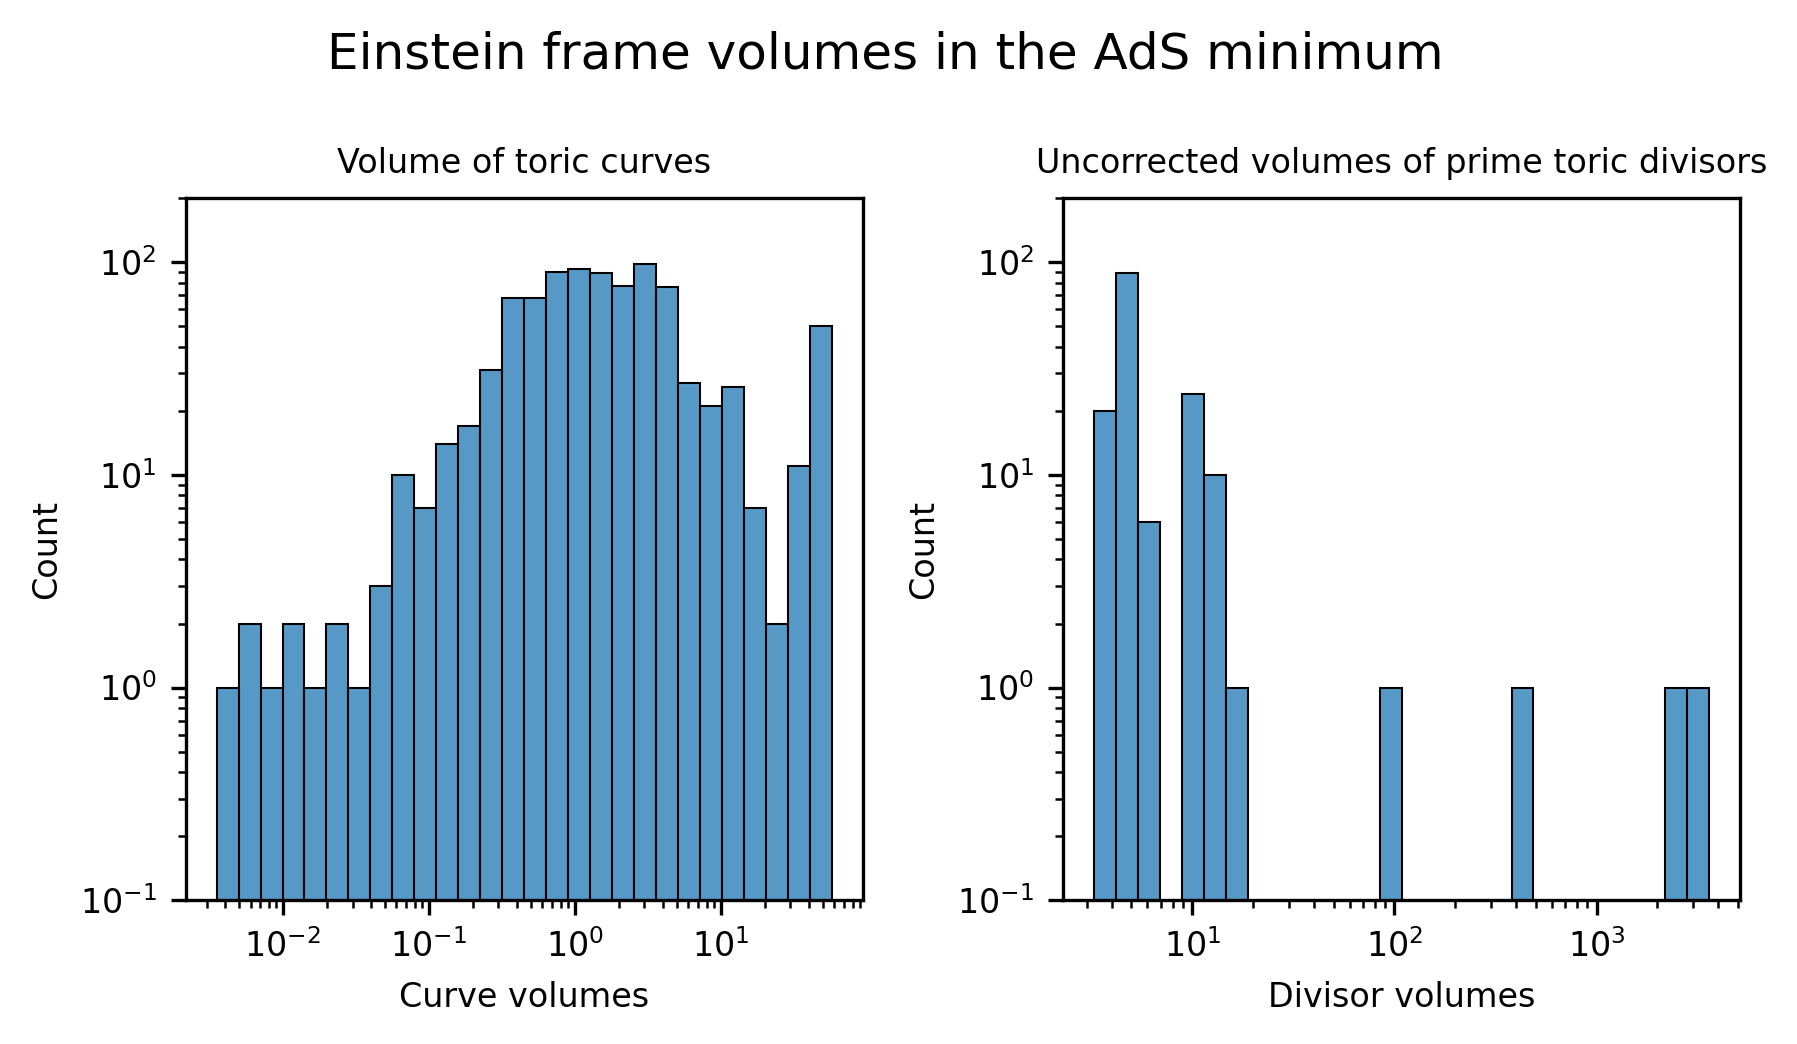

In [26]:
fig,axs = plt.subplots(1,2,dpi=300,figsize=(6,3.5))


minx = min(curve_volumes)/2
maxx = max(curve_volumes)*2
use_log = True
maxy = 200


fs_legend=8
fs_xlabel = 8
fs_suptitle=12
fs_title=10


sn.histplot(x=curve_volumes,log_scale=True,ax=axs[0])

axs[0].set_title("Volume of toric curves",fontsize = fs_title-2)
axs[0].set_xlabel("Curve volumes",fontsize = fs_xlabel)
axs[0].set_ylabel("Count",fontsize = fs_xlabel)
axs[0].tick_params(axis='both', which='major', labelsize=fs_xlabel)
axs[0].tick_params(axis='both', which='minor', labelsize=fs_xlabel)

if use_log:
    axs[0].set_yscale("log")
    axs[0].set_ylim(0.1,maxy)
else:
    axs[0].set_ylim(0,maxy)

minx = min(div_volumes)/2
maxx = max(div_volumes)*2

sn.histplot(x=div_volumes,log_scale=True,ax=axs[1])

axs[1].set_title("Uncorrected volumes of prime toric divisors",fontsize = fs_title-2)
axs[1].set_xlabel("Divisor volumes",fontsize = fs_xlabel)
axs[1].set_ylabel("Count",fontsize = fs_xlabel)
axs[1].tick_params(axis='both', which='major', labelsize=fs_xlabel)
axs[1].tick_params(axis='both', which='minor', labelsize=fs_xlabel)

if use_log:
    axs[1].set_yscale("log")
    axs[1].set_ylim(0.1,maxy)
else:
    axs[1].set_ylim(0,maxy)

plt.suptitle(f"Einstein frame volumes in the AdS minimum",fontsize = fs_suptitle)

plt.tight_layout()

plt.show()

### Constructing the leading order EFT

Let us next set up the computation in the leading order EFT. To begin with, we can look at the O-planes:

In [27]:
O7s = example_5_1["O7s"]
O3s = example_5_1["O3s"]
print("O7-planes: ", O7s)
print(f"O3-planes: {O3s[:4]} ...")

O7-planes:  [1, 3, 4, 5, 6, 7, 8, 9, 11, 14, 17, 18, 20, 24, 25, 30, 32, 37, 38, 40, 46, 62, 68, 78, 80, 90, 92, 106, 108, 112, 120, 122, 134, 136, 147, 12]
O3-planes: [[1, 44, 139, 1], [49, 145, 151, 1], [117, 131, 139, 1], [14, 56, 59, 1]] ...


This means e.g. that we have O7-planes on $x_1=0$ as well as a single O3-plane on $x_1=x_{44}=x_{139}=0$.

Then let us grab the information about the SUSY AdS minimum. Recall that the values of $g_s$ and $W_0$ that we verified above are

In [28]:
# Grab values for W0 and gs for the SUSY minimum
gs = example_5_1["SUSY gs"]
W0 = example_5_1["SUSY W0"]
W0 = np.abs(W0)
print(f"gs = {gs}")
print(f"W0 = {W0}")

gs = 0.07321255142562691
W0 = 0.010311191830195512


Then we need the point $\mathbf{t}_{\mathrm{AdS}}$ of the AdS minimum in Kähler moduli space together with the corresponding values for the $C_4$ axions:

In [29]:
kahler = np.array(example_5_1["kahler AdS"])
phi = np.array(example_5_1["phi AdS"])
kahler.shape, phi.shape

((150,), (150,))

Both correspond to $h^{1,1}$-dimensional vectors in form of an `numpy.ndarray`.

To verify our solutions, we also have to collect GV invariants plus the associated curves

In [30]:
GVs = np.array(example_5_1["GVs AdS"])
GVs.shape

(810, 151)

We find that there are in total 810 curves being considered for our computation. We can compute their string frame volumes as follows:

In [31]:
curve_charges = GVs[:,:-1]
kahler_st = kahler*np.sqrt(gs)
curve_volumes = curve_charges@kahler_st
np.sort(curve_volumes)[:5]

array([0.00175676, 0.00276206, 0.00859153, 0.01348705, 0.0154283 ])

We can make yet another plot to illustrate the distribution for the curve volumes:

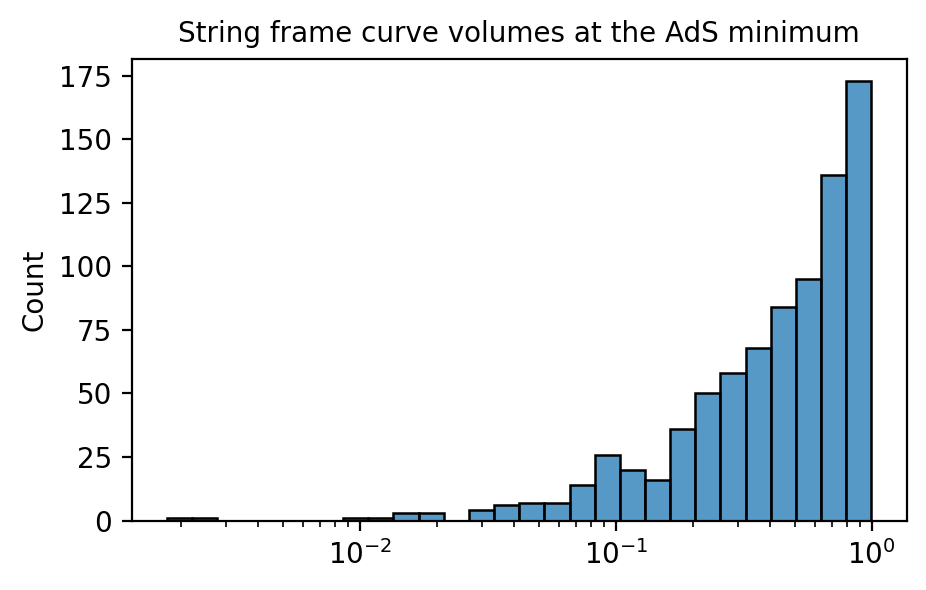

In [32]:
fig = plt.figure(dpi=200,figsize=(5,3))
sn.histplot(curve_volumes,log_scale=True)
plt.title("String frame curve volumes at the AdS minimum",fontsize=10)
plt.show()

Lastly, to compute the scalar potential, we have to define the relevant quantities entering e.g. the non-perturbative superpotential:

In [33]:
rigid_list = np.array(example_5_1["rigid divisors"])
dual_cox = np.array(example_5_1["dual coxeter numbers"])
Pfaffians = np.array(example_5_1["Pfaffians"])
bfield = np.array(example_5_1["bfield"])

As discussed in our paper, we only take the contributions from pure rigid prime toric divisors into account. In our model, we find that all rigid prime toric divisors are actually pure:

In [34]:
example_5_1["pure rigids AdS"]==example_5_1["rigid divisors"]

True

Since all rigids are actually pure rigid in the phase of the AdS minimum, we can compute the scalar potential and its gradient by using the full list of rigid divisors.

In [35]:
# Compute gradient and value of the potential
V = potential_km(cy,kahler,phi,rigid_list,dual_cox,W0,gs,Pfaffians,GV=GVs,bfield=bfield,vtilde=example_5_1["SUSY volTilde"])
dV = gradient_potential_km(cy,kahler,phi,rigid_list,dual_cox,W0,gs,Pfaffians,return_potential=False,GV=GVs,bfield=bfield,vtilde=example_5_1["SUSY volTilde"])

print("Maximum of the absolute values of the gradient of V at the minimum: ",np.max(np.abs(dV)))
print("Maximum ratio |dV/V|: ",np.max(np.abs(dV)/np.abs(V)))

print("")

print("Value of V at the minimum: ",V)
print("Value expected: ",example_5_1["V AdS"])
print("AdS vacuum energy matches expected value: ", np.abs(V-example_5_1["V AdS"])<1e-5)

Maximum of the absolute values of the gradient of V at the minimum:  5.18157683907993e-25
Maximum ratio |dV/V|:  1.1444906029076204e-06

Value of V at the minimum:  -4.527408810448896e-19
Value expected:  -4.527408810448888e-19
AdS vacuum energy matches expected value:  True


Note that, since the value of the potential is computed also in the gradient function `gradient_potential_km`, we can use the optional `return_potential` to return also the value of the scalar potential at the minimum by just calling `gradient_potential_km`:

In [36]:
# Compute the gradient of the scalar potential and the value of the scalar potential itself in one go...
dV,V = gradient_potential_km(cy,kahler,phi,rigid_list,dual_cox,W0,gs,Pfaffians,return_potential=True,GV=GVs,bfield=bfield,vtilde=example_5_1["SUSY volTilde"])

print("Maximum |dV|: ",np.max(np.abs(dV)))
print("Maximum ratio |dV/V|: ",np.max(np.abs(dV)/np.abs(V)))

print("")

print("Value of V at the minimum: ",V)
print("Value expected: ",example_5_1["V AdS"])
print("AdS vacuum energy matches expected value: ", np.abs(V-example_5_1["V AdS"])<1e-5)

Maximum |dV|:  5.18157683907993e-25
Maximum ratio |dV/V|:  1.1444906029076214e-06

Value of V at the minimum:  -4.527408810448892e-19
Value expected:  -4.527408810448888e-19
AdS vacuum energy matches expected value:  True


Next, we can compute the corrected CY volume and divisor volumes as defined in Eq. (2.71) and (2.73) respectively.
To this end, we implemented two functions `compute_corrected_divisor_volumes` and `compute_corrected_cy_volume` in [kahler_stabilisation.py](./../kahler_stabilisation.py):

In [37]:
print("Comparing volumes at the minimum...")

print("")

corrected_divisor_volumes = compute_corrected_divisor_volumes(cy,kahler,gs,bfield=bfield,GV=GVs)

print("Corrected divisor volumes match expected value: ", np.abs(np.max(corrected_divisor_volumes-np.array(example_5_1["corrected divisor volumes AdS"])))<1e-5)

CY_volume_str_frame = compute_corrected_cy_volume(cy,kahler,gs,bfield=bfield,GV=GVs)

print("Corrected CY volume matches expected value", np.abs(np.max(example_5_1["corrected CY volume AdS"]*gs**(3/2)-CY_volume_str_frame))<1e-5)

Comparing volumes at the minimum...

Corrected divisor volumes match expected value:  True
Corrected CY volume matches expected value True


There is one caveat however: above we were not particularly careful about how we handeled the prime toric divisor intersecting the conifold. Indeed, we can check that in the above computation, its contribution to the superpotential was turned on, i.e., it had a non-vanishing Pfaffian:

In [38]:
Pfaffians = np.array(example_5_1["Pfaffians"])
Pfaffians[example_5_1["coni-deleted divisor"]-1]

0.020210652027623288

This should of course not be the case. Let us turn off the conifold divisor by setting the corresponding value of the Pfaffian to zero:

In [39]:
Pfaffians[example_5_1["coni-deleted divisor"]-1] = 0.
Pfaffians[example_5_1["coni-deleted divisor"]-1]

0.0

Running through the same steps as before, we find

In [40]:
dV,V = gradient_potential_km(cy,kahler,phi,rigid_list,dual_cox,W0,gs,Pfaffians,return_potential=True,GV=GVs,bfield=bfield,vtilde=example_5_1["SUSY volTilde"])

print("Maximum |dV|: ",np.max(np.abs(dV)))
print("Maximum ratio |dV/V|: ",np.max(np.abs(dV)/np.abs(V)))

print("")

print("Computed vacuum energy: ",V)
print("Value expected: ",example_5_1["V AdS"])
print("dS vacuum energy matches expected value: ", np.abs(V-example_5_1["V AdS"])<1e-5)

print("")

print("Comparing volumes at the minimum...")

print("")

corrected_divisor_volumes = compute_corrected_divisor_volumes(cy,kahler,gs,bfield=bfield,GV=GVs)

print("Corrected divisor volumes match expected value: ", np.abs(np.max(corrected_divisor_volumes-np.array(example_5_1["corrected divisor volumes AdS"])))<1e-5)

CY_volume_str_frame = compute_corrected_cy_volume(cy,kahler,gs,bfield=bfield,GV=GVs)

print("Corrected CY volume matches expected value: ", np.abs(np.max(example_5_1["corrected CY volume AdS"]*gs**(3/2)-CY_volume_str_frame))<1e-5)

Maximum |dV|:  5.18157683907993e-25
Maximum ratio |dV/V|:  1.1444906029076214e-06

Computed vacuum energy:  -4.527408810448892e-19
Value expected:  -4.527408810448888e-19
dS vacuum energy matches expected value:  True

Comparing volumes at the minimum...

Corrected divisor volumes match expected value:  True
Corrected CY volume matches expected value:  True


Virtually nothing changes because our minima are such that the relevant divisor has a large volume implying that its contribution is essentially absent:

In [41]:
coni_divisor_volume = corrected_divisor_volumes[example_5_1["coni-deleted divisor"]-1]
coni_divisor_volume

94.55674390944112

Indeed, we can see that this is by almost a factor of 10 larger than the next largest volume in the list of corrected divisor volumes computed above

In [42]:
np.sort(corrected_divisor_volumes[corrected_divisor_volumes<=coni_divisor_volume+0.1])[::-1][:5]

array([94.55674391, 10.30653998,  9.85168591,  8.5926827 ,  8.51670413])

Hence, the contributions from the conifold intersecting divisor are so small compared to the other rigid divisors that it virtually makes no difference for these solutions whether or not we include it in the computation. However, it is of course **necessary** to remove the divisor from the list of contributing divisors to the superpotential by setting the Pfaffian to zero.

## The dS minimum

### Constructing and working with the CY geometry

Let us now construct the CY geometry in which the dS minimum lives. Using the polytope `p` from above, we can obtain the FRST hosting the dS minimum by using the `heights dS` entry in our dataframe

In [43]:
# Grab triangulation
t_uplift = p.triangulate(heights = np.array(example_5_1["heights dS"]))
t_uplift

A fine, regular, star triangulation of a 4-dimensional point configuration with 155 points in ZZ^4

The above FRST defines a CY threefold which is simply computed here:

In [44]:
cy_uplift = t_uplift.get_cy()
cy_uplift

A Calabi-Yau 3-fold hypersurface with h11=150 and h21=8 in a 4-dimensional toric variety

Again, we can compute the *uncorrected* CY volume and the volumes of all prime toric divisors and curves in the toric Mori cone as follows. We specify a point in Kähler moduli space, namely the location of the dS minimum `kahler dS`, and compute the corresponding volumes by using basic CYTools built-in functions:

In [45]:
kahler_uplift = np.array(example_5_1["kahler dS"])
cy_volume_uncorrected = cy.compute_cy_volume(kahler_uplift)
div_volumes = cy.compute_divisor_volumes(kahler_uplift)
curve_volumes = cy.compute_curve_volumes(kahler_uplift)

Let us make plots for these really quickly:

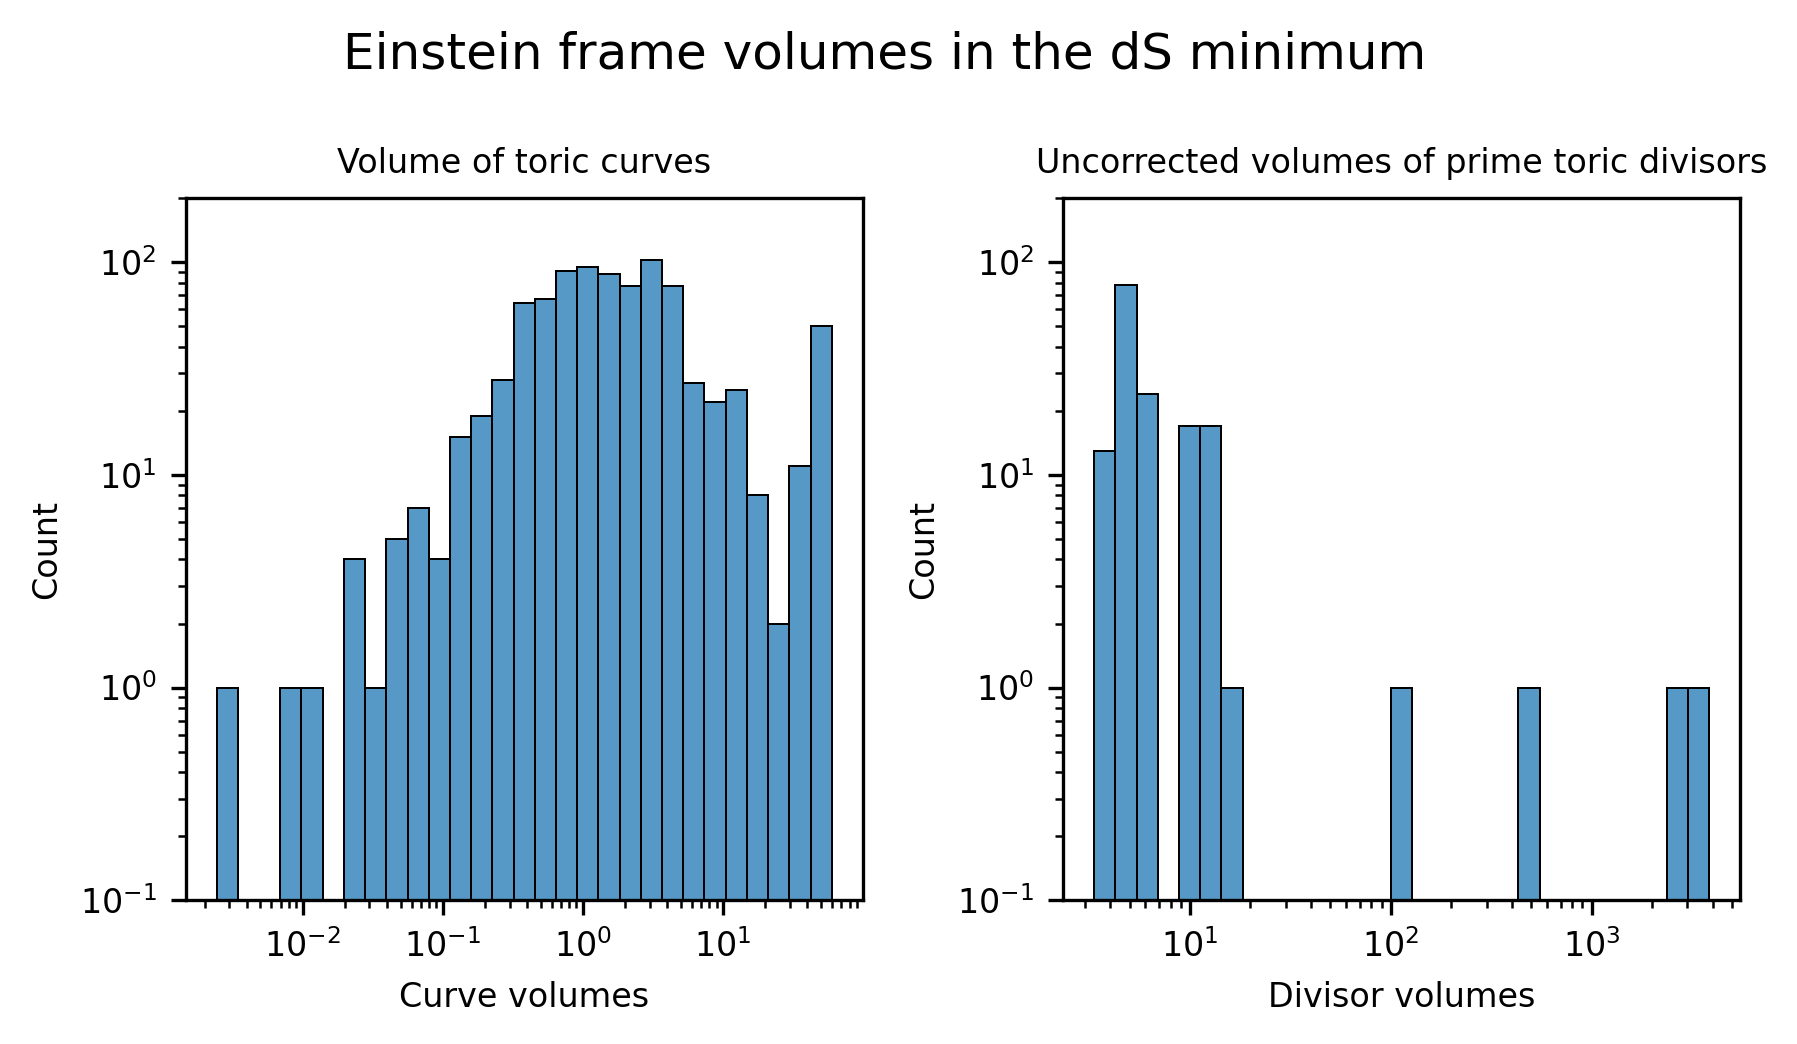

In [46]:
fig,axs = plt.subplots(1,2,dpi=300,figsize=(6,3.5))


minx = min(curve_volumes)/2
maxx = max(curve_volumes)*2
use_log = True
maxy = 200


fs_legend=8
fs_xlabel = 8
fs_suptitle=12
fs_title=10


sn.histplot(x=curve_volumes,log_scale=True,ax=axs[0])

axs[0].set_title("Volume of toric curves",fontsize = fs_title-2)
axs[0].set_xlabel("Curve volumes",fontsize = fs_xlabel)
axs[0].set_ylabel("Count",fontsize = fs_xlabel)
axs[0].tick_params(axis='both', which='major', labelsize=fs_xlabel)
axs[0].tick_params(axis='both', which='minor', labelsize=fs_xlabel)

if use_log:
    axs[0].set_yscale("log")
    axs[0].set_ylim(0.1,maxy)
else:
    axs[0].set_ylim(0,maxy)

minx = min(div_volumes)/2
maxx = max(div_volumes)*2

sn.histplot(x=div_volumes,log_scale=True,ax=axs[1])

axs[1].set_title("Uncorrected volumes of prime toric divisors",fontsize = fs_title-2)
axs[1].set_xlabel("Divisor volumes",fontsize = fs_xlabel)
axs[1].set_ylabel("Count",fontsize = fs_xlabel)
axs[1].tick_params(axis='both', which='major', labelsize=fs_xlabel)
axs[1].tick_params(axis='both', which='minor', labelsize=fs_xlabel)

if use_log:
    axs[1].set_yscale("log")
    axs[1].set_ylim(0.1,maxy)
else:
    axs[1].set_ylim(0,maxy)

plt.suptitle(f"Einstein frame volumes in the dS minimum",fontsize = fs_suptitle)

plt.tight_layout()

plt.show()

### Constructing the leading order EFT

Let us next set up the computation in the leading order EFT. As above, we define the values of $g_s$ and $W_0$ as follows

In [47]:
# Grab values for W0 and gs 
gs = example_5_1["gs"]
W0 = example_5_1["W0"]
W0 = np.abs(W0)
print(f"gs = {gs}")
print(f"W0 = {W0}")

gs = 0.06569470261013641
W0 = 0.011498101152307332


Then we need the point $\mathbf{t}_{\mathrm{dS}}$ of the 
dS minimum in Kähler moduli space together with the corresponding values for the $C_4$ axions:

In [48]:
kahler_uplift = np.array(example_5_1["kahler dS"])
phi_uplift = np.array(example_5_1["phi dS"])
kahler_uplift.shape, phi_uplift.shape

((150,), (150,))

Both correspond to $h^{1,1}$-dimensional vectors in form of an `numpy.ndarray`.

To verify our solutions, we also have to collect GV invariants plus the associated curves

In [49]:
GVs_uplift = np.array(example_5_1["GVs dS"])
GVs_uplift.shape

(833, 151)

We find that there are in total 833 curves being considered for our computation. We can compute their string frame volumes as follows:

In [50]:
curve_charges = GVs_uplift[:,:-1]
kahler_st = kahler_uplift*np.sqrt(gs)
curve_volumes = curve_charges@kahler_st
np.sort(curve_volumes)[:5]

array([0.00062469, 0.00326584, 0.00362106, 0.0052592 , 0.0113234 ])

We can make yet another plot to illustrate the distribution for the curve volumes:

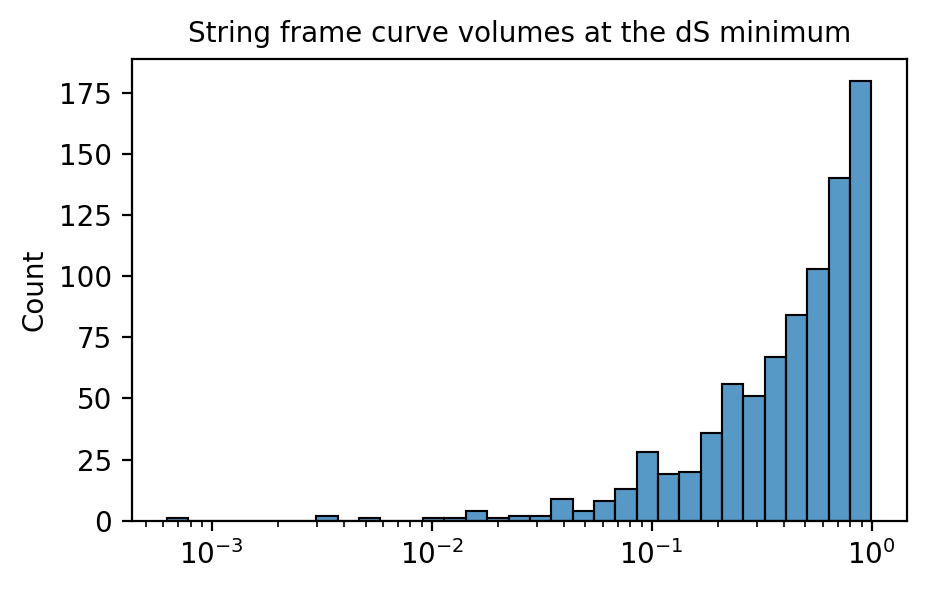

In [51]:
fig = plt.figure(dpi=200,figsize=(5,3))
sn.histplot(curve_volumes,log_scale=True)
plt.title("String frame curve volumes at the dS minimum",fontsize=10)
plt.show()

Lastly, to compute the scalar potential, we have to define the relevant quantities entering e.g. the non-perturbative superpotential:

In [52]:
rigid_list = np.array(example_5_1["rigid divisors"])
dual_cox = np.array(example_5_1["dual coxeter numbers"])
Pfaffians = np.array(example_5_1["Pfaffians"])
# Deleting conifold divisor
Pfaffians[example_5_1["coni-deleted divisor"]-1] = 0.
bfield = np.array(example_5_1["bfield"])

As discussed in our paper, we only take the contributions from pure rigid prime toric divisors into account. In our model, we find that all rigid prime toric divisors are actually pure:

In [53]:
example_5_1["pure rigids dS"]==example_5_1["rigid divisors"]

True

Since all rigids are actually pure rigid in the phase of the dS minimum, we can compute the scalar potential and its gradient by using the full list of rigid divisors.

In [54]:
# Grab uplift information
c_uplift = example_5_1["c uplift"]
CSFterm = example_5_1["CSFterm"]

# Compute the gradient of the scalar potential and the value of the scalar potential itself in one go...
dV,V = gradient_potential_km(cy_uplift,kahler_uplift,phi_uplift,rigid_list,dual_cox,W0,gs,Pfaffians,return_potential=True,GV=GVs_uplift,
                             bfield=bfield,vtilde=example_5_1["volTilde"],uplift=True,c_uplift=c_uplift,CSFterm=CSFterm)

print("Maximum |dV|: ",np.max(np.abs(dV)))
print("Maximum ratio |dV/V|: ",np.max(np.abs(dV)/np.abs(V)))

print("")

print("Computed vacuum energy: ",V)
print("Value expected: ",example_5_1["V dS"])
print("dS vacuum energy matches expected value: ", np.abs(V-example_5_1["V dS"])<1e-5)

Maximum |dV|:  7.948885700099203e-26
Maximum ratio |dV/V|:  4.1034340674708637e-07

Computed vacuum energy:  1.9371301133146923e-19
Value expected:  1.9371301133146932e-19
dS vacuum energy matches expected value:  True


Next, we can compute the corrected CY volume and divisor volumes as defined in Eq. (2.71) and (2.73) respectively.
To this end, we implemented two functions `compute_corrected_divisor_volumes` and `compute_corrected_cy_volume` in [kahler_stabilisation.py](./../kahler_stabilisation.py):

In [55]:
print("Comparing volumes at the minimum...")

print("")

corrected_divisor_volumes = compute_corrected_divisor_volumes(cy_uplift,kahler_uplift,gs,bfield=bfield,GV=GVs_uplift)

print("Corrected divisor volumes match expected value: ", np.abs(np.max(corrected_divisor_volumes-np.array(example_5_1["corrected divisor volumes dS"])))<1e-5)

CY_volume_str_frame = compute_corrected_cy_volume(cy_uplift,kahler_uplift,gs,bfield=bfield,GV=GVs_uplift)

print("Corrected CY volume matches expected value", np.abs(np.max(example_5_1["corrected CY volume dS"]*gs**(3/2)-CY_volume_str_frame))<1e-5)

Comparing volumes at the minimum...

Corrected divisor volumes match expected value:  True
Corrected CY volume matches expected value True


**In summary, we verified the values stated in section 5.1 of our paper.**